In [ ]:
# import van het model uit resnet_cuda4.ipynb

In [1]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_classes = 4

# Resnet model
# model = resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)
# model = model.to(device)

model = torch.load('Team_Complete_Model.pth')
model = model.to(device)
model.eval()

cuda


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=100352, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=4, bias=True)
  (12): Dropout(p=0.5, inplace=False)
)

In [2]:
image_size = 224
batch_size = 8

test_dir = "../data/Test"

# Define the transformations for test data before entering the neural network
transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),                     # Resize images to 224x224 pixels
    transforms.ToTensor(),                                           # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

# Load the test dataset
test_dataset = ImageFolder(test_dir, transform=transform_test)

test_dataset.class_to_idx
idx2class = {v: k for k, v in test_dataset.class_to_idx.items()}
idx2class


# Create DataLoaders for managing the data batches
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def test(model, criterion, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    accuracy = 100.0 * correct / total
    return running_loss / len(test_loader), accuracy



In [3]:
# !python -m torch.utils.collect_env

In [3]:
criterion = nn.CrossEntropyLoss()

test_loss, test_accuracy = test(model, criterion, test_loader, device)

In [4]:
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.9276, Test Accuracy: 65.00%


cuda
[[26  1  1  2]
 [ 6 15  1  2]
 [ 0  3 34  1]
 [11  4 10  3]]


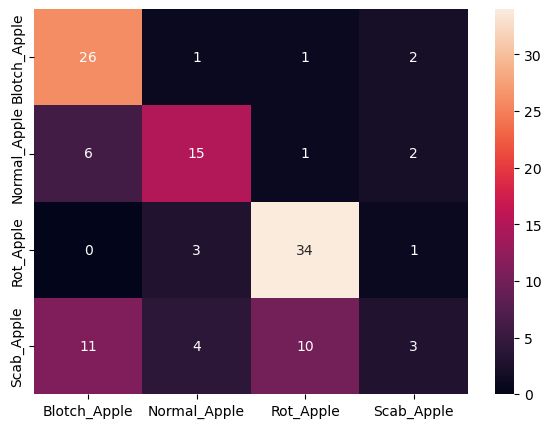

In [5]:


print(device)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs) # Feed Network
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    # output=output.to(device)
    y_pred.extend(output) # Save Prediction
        
    labels = labels.data.cpu().numpy()
    # labels=labels.to(device)
    y_true.extend(labels) # Save Truth


# # constant for classes
classes = ('0','1','2','3')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax);



In [ ]:
# maak op de assen onderscheid tussen y en yhat

In [ ]:
# AQL berekening toevoegen

In [42]:
# function to show the images


def reverse_normalize(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image.clone()
    for i in range(3):
        image[i] = (image[i] * std[i]) + mean[i]
    return image

def show_batch(train_d, val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][7]
    # image_test = data_test[0][0]
    image_val = data_val[0][3]
    label_train = data_train[1][0]
    # label_test = data_test[1][0]
    label_val = data_val[1][0]

    # dit hele blok kan uit als je geen normalisatie gebruikt:
    # Reverse the normalization of the images
    image_train = reverse_normalize(image_train)
    # image_test = reverse_normalize(image_test)
    image_val = reverse_normalize(image_val)

    # Convert the image tensors to NumPy arrays and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    # np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 2)

    # Display the image in the first subplot
    axes[0].imshow(np_image_train)
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the image in the third subplot
    axes[1].imshow(np_image_val)
    axes[1].set_title(f'{label_val}, {image_val.shape}')

    # # Display the image in the second subplot
    # axes[2].imshow(np_image_test)
    # axes[2].set_title(f'{label_test}, {image_test.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()


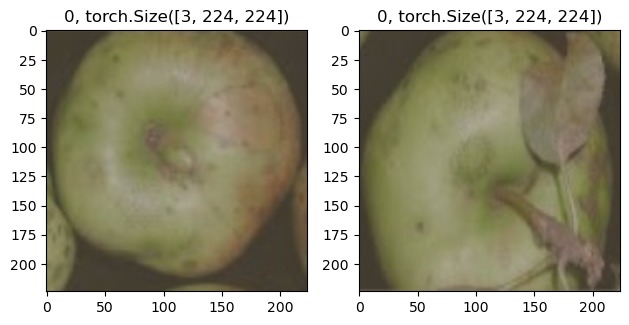

In [43]:
show_batch(test_loader, test_loader)
